# EGM algorithm for the firms problem with 2 endogenous states

## Setup - import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import EGM_firms_problem_dyn_K_L as EGM
import SSJ_ext.utils as utils 
import SSJ_ext.jacobian as jac

## Choose parameters and solve steady state

In [2]:
# parameters 
pars = {'alpha' : 0.3, 'beta' : 0.4, 'p' : 1, 'pI' : 1.2, 'delta' : 0.01, 'psi' : 2, 'r' : 0.03, 'w' : 0.6,
        'm' : 0.5, 'kappaV' : 0.05 * 0.6 / 0.5, 'ptheta' : 0.3, 'destr' : 0.1}

# grid for kapital and labor 
k_grid = 15 + utils.agrid(amax=10, n=120)
l_grid = 1  + utils.agrid(amax=3, n=100)

# grid for idiosynchratic productivty
# no heterogeighty for now to compare with jac solution (see below) so set variance to 0 (1e-06)
rho, sigma, nZ = 0.9, 1e-06, 2

# starting values for backwards iteration 
cont_val_l = np.zeros([nZ, l_grid.size, k_grid.size])
cont_val_l[:,:,:] = ((1-pars['destr']) * pars['kappaV']/pars['m']) / (1+pars['r'])
cont_val_k = np.zeros([nZ, l_grid.size, k_grid.size])
cont_val_k[:,:,:] = ((1-pars['delta']) * pars['pI']) / (1+pars['r'])

pars.update({'k_grid':k_grid, 'l_grid':l_grid, 'rho':rho, 'sigma':sigma, 'nZ':nZ,
            'cont_val_l':cont_val_l, 'cont_val_k':cont_val_k})

# iterate until steady state is reached 
ss = EGM.Firm_prob.ss(**pars, accelerated_it = False, noisy=True)



Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Iteration: 1000
Iteration: 1100
Iteration: 1200
Iteration: 1300
Iteration: 1400
Iteration: 1500
Iteration: 1600
Iteration: 1700
Iteration: 1800
Converged after : 1831 iterations


## IRF to announced price shock 

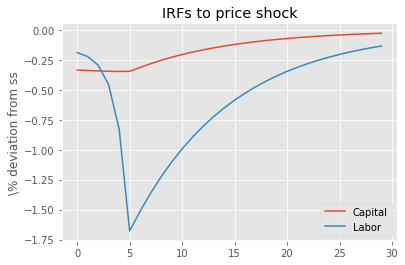

In [5]:
Time = 300     
# ttt = np.arange(0,Time)
ann = 5
dp = np.zeros(Time)
dp[ann:] = - 0.01  * 0.9**(np.arange(Time-ann))
J      = EGM.Firm_prob.jac(ss, Time, ['p'])  # get jacobian    

dK = J['K']['p'] @ dp * 100 / ss['K']
dL = J['L']['p'] @ dp * 100 / ss['L']

plt.plot(dK[:30], label='Capital')
plt.plot(dL[:30], label='Labor')
plt.plot(np.zeros(30), color = 'black', linestyle = '--')
plt.title('IRFs to price shock')
plt.ylabel(r'\% deviation from ss')
plt.legend()
plt.show() 

## Comparison

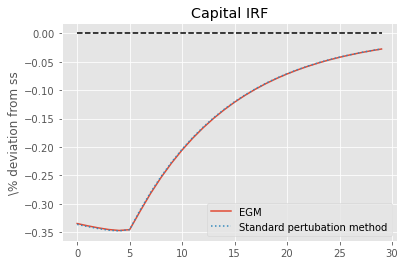

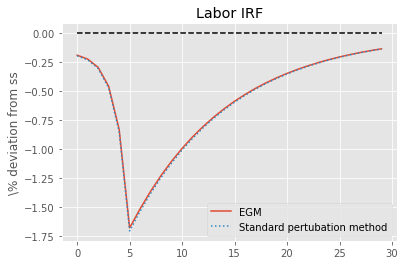

In [14]:
# Since there is no heterogeneity in the above model we can compare the solution to the one obtained 
# from a simple model solved using either standard pertubation methods (dynare etc.) or full non-linear solution
# the two should be identical (depends on grids though)

from solved_block import solved

# define block with equations
@solved(unknowns=['K', 'L'], targets=['K_res', 'L_res'])
def firm(alpha, beta, p, pI, Z, psi, K, L, ptheta, kappaV, destr, m, r, w, delta):
    theta  = ptheta /2 * (L(+1)/L-1)**2
    theta_prior  = ptheta /2 * (L/L(-1)-1)**2
    dtheta = ptheta * (L(+1)/L-1)      
    L_res = beta*p*Z*K**(alpha)*L**(beta-1) + ((1-destr)*kappaV/m(+1) + dtheta*L(+1)/L - theta)/(1+r(+1)) - (w + kappaV/m + theta_prior)
    
    phi  = psi /2 * (K(+1)/K-1)**2
    phi_prior  = psi /2 * (K/K(-1)-1)**2
    dphi = psi * (K(+1)/K-1)
    I = K - (1-delta) * K(-1)
    K_res = alpha*p*Z*K**(alpha-1)*L**beta + ((1-delta)*pI + dphi*K(+1)/K - phi)/(1+r(+1)) - (pI + phi_prior)
    Y = Z * K**alpha * L**beta
    profit = p * Y  - w*L - pI*I - phi
    return L_res, K_res, Y, profit, I 

Kss, Lss = ss['K'],ss['L']

ss.update({'Z':1})

J_simple =   firm.jac(ss, Time, ['p'])     

dY_simple = J_simple['Y']['p'] @ dp * 100 / ss['Y']
dK_simple = J_simple['K']['p'] @ dp * 100 / ss['K']
dL_simple   = J_simple['L']['p'] @ dp * 100 / ss['L']

plt.plot(dK[:30], label='EGM')
plt.plot(dK_simple[:30], ':', label='Standard pertubation method')
plt.plot(np.zeros(30), color = 'black', linestyle = '--')
plt.title('Capital IRF')
plt.ylabel(r'\% deviation from ss')
plt.legend()
plt.show() 

plt.plot(dL[:30], label='EGM')
plt.plot(dL_simple[:30], ':', label='Standard pertubation method')
plt.plot(np.zeros(30), color = 'black', linestyle = '--')
plt.title('Labor IRF')
plt.ylabel(r'\% deviation from ss')
plt.legend()
plt.show() 